In [1]:
#import
import pandas as pd
import numpy as np
from Levenshtein import distance
import matplotlib.pyplot as plt
import fastwer

In [2]:
#from Dan (02/19)
from torch import cuda
import torch


device = 'cuda' if cuda.is_available() else 'cpu'
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# cuda.empty_cache()
print(device)

cuda


In [3]:
#directory
# output_dir_ = '/home/dw16/models/inferences/' # this is just the words
aligned_dataset_dir = '/projects/RTM/aligned_sentences/batched_sentences/' # trying new sentences

#loading in data
new_b = pd.read_csv(aligned_dataset_dir + "batch_s000001.csv")
new_b

,source,target
0,brielituess being within 1” of oue of the 128 ...,brightness being within $''$ of one of the 428...
1,We present the I magnitude. LK. colours. nüas...,"We present the I magnitude, I-K colours, mass..."
2,Comparison with the xoperties of the general ...,Comparison with the properties of the general...
3,We preseut iu Fie.,We present in Fig.
4,5 the I vs. LK color magnitude diagram or MOI...,\ref{ikcd} the I vs. I-K color magnitude diag...
...,...,...
9995,These observations were obtained within two w...,These observations were obtained within two w...
9996,An end of night neasurement from OIIP at a la...,An end of night measurement from OHP at a lar...
9997,At this conference we learucd from C. Marcy t...,At this conference we learned from G. Marcy t...
9998,Weather permitting. we have since then attemp...,"Weather permitting, we have since then attemp..."


In [39]:
#only wanna output the type and
def reset_types(input_string):
    if isinstance(input_string, float):
        return str(input_string)
    elif isinstance(input_string, str):
        output_string = ""

        for char in input_string:
            if char != "@" and char != "^":
                if char == "\\" :
                    output_string += 'w'
                if char != " ":
                    output_string += 'W'
                else:
                    output_string += char
            else:
                output_string += char

    return output_string
## include the $$ and the \ref{___}
## matching the opening and closing brackets
##option: use the datast that already have the aligned type and train with just words! --> will help dealing with special formats and characters.

In [40]:
#plain text along --> need certain types of 
# --> latex inline math formula --> $$ --> something I can read in.

In [17]:
new_b['aligned source'] = new_b['source'].apply(reset_types)
new_b['aligned target'] = new_b['target'].apply(reset_types)
new_b.head()

,source,target,aligned source,aligned target
0,brielituess being within 1” of oue of the 128 ...,brightness being within $''$ of one of the 428...,WWWWWWWWWWW WWWWW WWWWWW WW WW WWW WW WWW WWW ...,WWWWWWWWWW WWWWW WWWWWW WWWW WW WWW WW WWW WWW...
1,We present the I magnitude. LK. colours. nüas...,"We present the I magnitude, I-K colours, mass...",WW WWWWWWW WWW W WWWWWWWWWW WWW WWWWWWWW WWWW...,WW WWWWWWW WWW W WWWWWWWWWW WWW WWWWWWWW WWWW...
2,Comparison with the xoperties of the general ...,Comparison with the properties of the general...,WWWWWWWWWW WWWW WWW WWWWWWWWW WW WWW WWWWWWW ...,WWWWWWWWWW WWWW WWW WWWWWWWWWW WW WWW WWWWWWW...
3,We preseut iu Fie.,We present in Fig.,WW WWWWWWW WW WWWW,WW WWWWWWW WW WWWW
4,5 the I vs. LK color magnitude diagram or MOI...,\ref{ikcd} the I vs. I-K color magnitude diag...,W WWW W WWW WW WWWWW WWWWWWWWW WWWWWWW WW WWW...,WWWWWWWWWW WWW W WWW WWW WWWWW WWWWWWWWW WWWW...


In [4]:
# Save the DataFrame to a CSV file
output_dir_ = '/home/dw16/models/inferences/' # this is just the words
# #just wordnew sentence
# ender = 'new_s_w'
# filename = output_dir_ + 's' + str(1000) + ender + '.csv' 
# new_b.to_csv(filename, index=False)

In [7]:
print(filename)

/home/dw16/models/inferences/s1000new_s_w.csv


In [17]:
#install
import numpy as np
import torch
import signal
from torch.utils.data import Dataset

from transformers import HfArgumentParser, TensorFlowBenchmark, TensorFlowBenchmarkArguments
import pandas as pd
from transformers import T5ForConditionalGeneration, AutoTokenizer
from transformers import TrainingArguments
from torch.utils.data import Dataset, DataLoader
from transformers import Trainer
from transformers import EarlyStoppingCallback

In [18]:
aligned_dataset_dir = '/projects/RTM/aligned_sentences/batched_sentences/' # trying new sentences
# output_dir = '/Users/dw16/Downloads/tmp/byt5_inline_cite_ref_small_words/' # this is just the words
output_dir = '/home/dw16/models/byt5_inline_cite_ref_ocr/' # this is just the words
output_dir_ = '/home/dw16/models/inferences/' # this is just the words
# ender = '_yelpfeast' # yelpfeast/byt5-base-english-ocr-correction
# ender = '_small_words' # 100k for training, 5k val
# ender = 'multilex' # 'ufal/byt5-small-multilexnorm2021-es''
ender = 'new_s_w'

In [19]:
wait_timeout = 2.0 # timeout in minutes
wait_timeout *= 60.0

In [20]:
class timeout:
    def __init__(self, seconds=1, error_message='Timeout'):
        self.seconds = seconds
        self.error_message = error_message
    def handle_timeout(self, signum, frame):
        raise TimeoutError(self.error_message)
    def __enter__(self):
        signal.signal(signal.SIGALRM, self.handle_timeout)
        signal.alarm(self.seconds)
    def __exit__(self, type, value, traceback):
        signal.alarm(0)

In [21]:
#'ufal/byt5-small-multilexnorm2021-es'
tokenizer = AutoTokenizer.from_pretrained(
    "ufal/byt5-small-multilexnorm2021-es",
    cache_dir=output_dir, 
#    max_length=4096
    max_new_tokens=4096
)

In [22]:
# snapshot = 'checkpoint-66000'  #for byt5-samll
snapshot = 'checkpoint-47500' #ocr
# snapshot = None

if snapshot == None:
    snapshots = glob(output_dir+'checkpoint*')
    order = []
    for s in snapshots:
        order.append(s.split('-')[-1])
    argsort = np.argsort(np.array(order).astype('int'))
    snapshot = np.array(snapshots)[argsort][-1]
else:
    snapshot = output_dir + snapshot

In [23]:
model = T5ForConditionalGeneration.from_pretrained(snapshot)
skip_specials = True
model.to("cuda");

In [15]:
# inds = np.arange(0,1000)
# text = new_b.iloc[inds]["aligned source"]
# text

0      WWWWWWWWWWW WWWWW WWWWWW WW WW WWW WW WWW WWW ...
1       WW WWWWWWW WWW W WWWWWWWWWW WWW WWWWWWWW WWWW...
2       WWWWWWWWWW WWWW WWW WWWWWWWWW WW WWW WWWWWWW ...
3                                     WW WWWWWWW WW WWWW
4       W WWW W WWW WW WWWWW WWWWWWWWW WWWWWWW WW WWW...
                             ...                        
995     WWWWW WW WWW WWWW WWW WWWWWWW WWW WWW WWWWWWW...
996     WWWWWWW WWWW WWWWWWWWWWW WWW WWWWWWWWWWWWWWWW...
997     WWWWW WWW WWWWWWWWWW WWWWWWWWWWWW WW WWWWWWW ...
998       WWWWWW WWWW WWWWWWWWWWWW WW WWW WWWWW WW WWWWW
999     WW WWW WWWWWWW WWW WWWW WWWWWW WWWW WWWWWW WW...
Name: aligned source, Length: 1000, dtype: object

In [16]:
# df2 = new_b.iloc[inds].copy()
# df2['predicted_text'] = None

# # df2 = new_b.iloc[inds].copy()
# # df2['predicted_text'] = None
# predicted_texts = []  # Create a new list to store predicted texts

# for i in range(text.shape[0]):
#     if i%100 == 0:
#         filename = output_dir_ + 's' + str(i) + ender + '.csv' 
#         df2.to_csv(filename, index=False)
#     try: 
#         with timeout(seconds=int(wait_timeout)):
#             inputs = tokenizer(text[i], padding="longest", return_tensors="pt")
#             #from dan code
#             #---
#             inputs = inputs.to("cuda")
#             #---
#             output = model.generate(**inputs)
#             output_text = tokenizer.decode(output[0], 
#                                             skip_special_tokens=skip_specials, 
#                                             clean_up_tokenization_spaces=True)
#             output_text = str(output_text)
#     except:
#         #import sys; sys.exit()
#         print(i, ': error or timeout in model')
#         output_text = np.nan
#         err = True
#     df2['predicted_text'][i] = output_text
# # filename = output_dir_ + 's' + str(len(inds)) + ender + '.csv' 
# df2.to_csv(filename, index=False)
# del df2
# del output_text
# del text

## Quantifying

In [5]:
#just wordnew sentence
new_s = pd.read_csv(output_dir_ + "s1000new_s_w.csv")
new_s

,source,target,aligned source,aligned target
0,brielituess being within 1” of oue of the 128 ...,brightness being within $''$ of one of the 428...,WWWWWWWWWWW WWWWW WWWWWW WW WW WWW WW WWW WWW ...,WWWWWWWWWW WWWWW WWWWWW WWWW WW WWW WW WWW WWW...
1,We present the I magnitude. LK. colours. nüas...,"We present the I magnitude, I-K colours, mass...",WW WWWWWWW WWW W WWWWWWWWWW WWW WWWWWWWW WWWW...,WW WWWWWWW WWW W WWWWWWWWWW WWW WWWWWWWW WWWW...
2,Comparison with the xoperties of the general ...,Comparison with the properties of the general...,WWWWWWWWWW WWWW WWW WWWWWWWWW WW WWW WWWWWWW ...,WWWWWWWWWW WWWW WWW WWWWWWWWWW WW WWW WWWWWWW...
3,We preseut iu Fie.,We present in Fig.,WW WWWWWWW WW WWWW,WW WWWWWWW WW WWWW
4,5 the I vs. LK color magnitude diagram or MOI...,\ref{ikcd} the I vs. I-K color magnitude diag...,W WWW W WWW WW WWWWW WWWWWWWWW WWWWWWW WW WWW...,WWWWWWWWWW WWW W WWW WWW WWWWW WWWWWWWWW WWWW...
...,...,...,...,...
9995,These observations were obtained within two w...,These observations were obtained within two w...,WWWWW WWWWWWWWWWWW WWWW WWWWWWWW WWWWWW WWW W...,WWWWW WWWWWWWWWWWW WWWW WWWWWWWW WWWWWW WWW W...
9996,An end of night neasurement from OIIP at a la...,An end of night measurement from OHP at a lar...,WW WWW WW WWWWW WWWWWWWWWWW WWWW WWWW WW W WW...,WW WWW WW WWWWW WWWWWWWWWWW WWWW WWW WW W WWW...
9997,At this conference we learucd from C. Marcy t...,At this conference we learned from G. Marcy t...,WW WWWW WWWWWWWWWW WW WWWWWWW WWWW WW WWWWW W...,WW WWWW WWWWWWWWWW WW WWWWWWW WWWW WW WWWWW W...
9998,Weather permitting. we have since then attemp...,"Weather permitting, we have since then attemp...",WWWWWWW WWWWWWWWWWW WW WWWW WWWWW WWWW WWWWWW...,WWWWWWW WWWWWWWWWWW WW WWWW WWWWW WWWW WWWWWW...


In [7]:
# new_s['source_word'] = None
# # create source word
# for i in range(new_s.shape[0]):
#     justword = ""
#     aligned_source = str(new_s["aligned source"][i])
#     source = str(new_s["source"][i])
    
#     for j in range(len(aligned_source)):
#         if j < len(source) and (aligned_source[j] == 'W' or aligned_source[j] == ' '):
#             justword += source[j]
    
#     new_s["source_word"][i] = justword

In [8]:
# new_s['target_word'] = None
# #create target word
# for i in range(new_s.shape[0]):
#     justword = ""
#     aligned_target = str(new_s["aligned target"][i])
#     target = str(new_s["target"][i])
    
#     for j in range(len(aligned_target)):
#         if j < len(target) and (aligned_target[j] == 'W' or aligned_target[j] == ' '):
#             justword += target[j]
    
#     new_s["target_word"][i] = justword

In [9]:
new_s.head()

,source,target,aligned source,aligned target,source_word,target_word
0,brielituess being within 1” of oue of the 128 ...,brightness being within $''$ of one of the 428...,WWWWWWWWWWW WWWWW WWWWWW WW WW WWW WW WWW WWW ...,WWWWWWWWWW WWWWW WWWWWW WWWW WW WWW WW WWW WWW...,brielituess being within 1” of oue of the 128 ...,brightness being within $''$ of one of the 428...
1,We present the I magnitude. LK. colours. nüas...,"We present the I magnitude, I-K colours, mass...",WW WWWWWWW WWW W WWWWWWWWWW WWW WWWWWWWW WWWW...,WW WWWWWWW WWW W WWWWWWWWWW WWW WWWWWWWW WWWW...,We present the I magnitude. LK. colours. nüas...,"We present the I magnitude, I-K colours, mass..."
2,Comparison with the xoperties of the general ...,Comparison with the properties of the general...,WWWWWWWWWW WWWW WWW WWWWWWWWW WW WWW WWWWWWW ...,WWWWWWWWWW WWWW WWW WWWWWWWWWW WW WWW WWWWWWW...,Comparison with the xoperties of the general ...,Comparison with the properties of the general...
3,We preseut iu Fie.,We present in Fig.,WW WWWWWWW WW WWWW,WW WWWWWWW WW WWWW,We preseut iu Fie.,We present in Fig.
4,5 the I vs. LK color magnitude diagram or MOI...,\ref{ikcd} the I vs. I-K color magnitude diag...,W WWW W WWW WW WWWWW WWWWWWWWW WWWWWWW WW WWW...,WWWWWWWWWW WWW W WWW WWW WWWWW WWWWWWWWW WWWW...,5 the I vs. LK color magnitude diagram or MOI...,\ref{ikcd} the I vs. I-K color magnitude diag...


In [10]:
# Save the DataFrame to a CSV file
output_dir_ = '/home/dw16/models/inferences/' # this is just the words
# #just wordnew sentence
ender = 'new_s_w'
filename = output_dir_ + 's' + str(10000) + ender + '.csv' 
new_s.to_csv(filename, index=False)

In [11]:
filename

'/home/dw16/models/inferences/s10000new_s_w.csv'

# Train with only words

In [37]:
new_w = pd.read_csv(output_dir_ + "s10000new_s_w.csv")
new_w.head()

,source,target,aligned source,aligned target,source_word,target_word
0,brielituess being within 1” of oue of the 128 GCs ij 2410 7.,brightness being within $''$ of one of the 428 GCs is $\times$ $^{-5}$.,WWWWWWWWWWW WWWWW WWWWWW WW WW WWW WW WWW WWW WWW WW WWWW WW,WWWWWWWWWW WWWWW WWWWWW WWWW WW WWW WW WWW WWW WWW WW WWWWWWWW W^WWWWWW,brielituess being within 1” of oue of the 128 GCs ij 2410 7.,brightness being within $''$ of one of the 428 GCs is $\times$ ${-5}$.
1,We present the I magnitude. LK. colours. nüasses ages and |Fe/II| metalicities of the four GCs suspected of hosting new BIICs in Table 2.. along with the two M31 GC BICS already identified: the magnitudes were obtained from he RBC: the masses. ages and mectalicitics were drawn from ? and 7.,"We present the I magnitude, I-K colours, masses ages and [Fe/H] metalicities of the four GCs suspected of hosting new BHCs in Table \ref{gcprops}, along with the two M31 GC BHCs already identified; the magnitudes were obtained from the RBC; the masses, ages and metalicities were drawn from \cit...",WW WWWWWWW WWW W WWWWWWWWWW WWW WWWWWWWW WWWWWWW WWWW WWW WWWWWWW WWWWWWWWWWWW WW WWW WWWW WWW WWWWWWWWW WW WWWWWWW WWW WWWWW WW WWWWW WWW WWWWW WWWW WWW WWW WWW WW WWWW WWWWWWW WWWWWWWWWWW WWW WWWWWWWWWW WWWW WWWWWWWW WWWW WW WWWW WWW WWWWWWW WWWW WWW WWWWWWWWWWWWW WWWW WWWWW WWWW W WWW WW,WW WWWWWWW WWW W WWWWWWWWWW WWW WWWWWWWW WWWWWW WWWW WWW WWWWWW WWWWWWWWWWWW WW WWW WWWW WWW WWWWWWWWW WW WWWWWWW WWW WWWW WW WWWWW WWWWWWWWWWWWWW WWWWW WWWW WWW WWW WWW WW WWWW WWWWWWW WWWWWWWWWWW WWW WWWWWWWWWW WWWW WWWWWWWW WWWW WWW WWWW WWW WWWWWWW WWWW WWW WWWWWWWWWWWW WWWW WWWWW WWWW WWWW...,We present the I magnitude. LK. colours. nüasses ages and |Fe/II| metalicities of the four GCs suspected of hosting new BIICs in Table 2.. along with the two M31 GC BICS already identified: the magnitudes were obtained from he RBC: the masses. ages and mectalicitics were drawn from ? and 7.,"We present the I magnitude, I-K colours, masses ages and [Fe/H] metalicities of the four GCs suspected of hosting new BHCs in Table \ref{gcprops}, along with the two M31 GC BHCs already identified; the magnitudes were obtained from the RBC; the masses, ages and metalicities were drawn from \cit..."
2,Comparison with the xoperties of the general GC population presentect we? sneeests that the GCs harboring BITC are nore luassive (brighter). aud redder / more metal rich than the general population.,"Comparison with the properties of the general GC population presented by \citet{peacock10} suggests that the GCs harboring BHCs are more massive (brighter), and redder / more metal rich than the general population.",WWWWWWWWWW WWWW WWW WWWWWWWWW WW WWW WWWWWWW WW WWWWWWWWWW WWWWWWWWWW WWW WWWWWWWW WWWW WWW WWW WWWWWWWWW WWWW WWW WWWW WWWWWWWW WWWWWWWWWWW WWW WWWWWW W WWWW WWWWW WWWW WWWW WWW WWWWWWW WWWWWWWWWWW,WWWWWWWWWW WWWW WWW WWWWWWWWWW WW WWW WWWWWWW WW WWWWWWWWWW WWWWWWWWW WW WWWWWWWWWWWWWWWWW WWWWWWWW WWWW WWW WWW WWWWWWWWW WWWW WWW WWWW WWWWWWW WWWWWWWWWWW WWW WWWWWW W WWWW WWWWW WWWW WWWW WWW WWWWWWW WWWWWWWWWWW,Comparison with the xoperties of the general GC population presentect we? sneeests that the GCs harboring BITC are nore luassive (brighter). aud redder / more metal rich than the general population.,"Comparison with the properties of the general GC population presented by \citet{peacock10} suggests that the GCs harboring BHCs are more massive (brighter), and redder / more metal rich than the general population."
3,We preseut iu Fie.,We present in Fig.,WW WWWWWWW WW WWWW,WW WWWWWWW WW WWWW,We preseut iu Fie.,We present in Fig.
4,5 the I vs. LK color magnitude diagram or MOI GCs: points represeu the whole GC xopulation with I aud Is maguitudes. open circles represent GCs in our field with associated X-rav endsson (see Barnard ο al.,"\ref{ikcd} the I vs. I-K color magnitude diagram for M31 GCs; points represent the whole GC population with I and K magnitudes, open circles represent GCs in our field with associ

In [38]:
new_w.iloc[4]

source                           5 the I vs. LK color magnitude diagram or MOI GCs: points represeu the whole GC xopulation with I aud Is maguitudes. open circles represent GCs in our field with associated X-rav endsson (see Barnard ο al.
target             \ref{ikcd} the I vs. I-K color magnitude diagram for M31 GCs; points represent the whole GC population with I and K magnitudes, open circles represent GCs in our field with associated X-ray emission (see Barnard et al.,
aligned source                   W WWW W WWW WW WWWWW WWWWWWWWW WWWWWWW WW WWW WWWW WWWWWW WWWWWWWW WWW WWWWW WW WWWWWWWWWW WWWW W WWW WW WWWWWWWWWWW WWWW WWWWWWW WWWWWWWWW WWW WW WWW WWWWW WWWW WWWWWWWWWW WWWWW WWWWWWW WWWW WWWWWWW W WWW
aligned target     WWWWWWWWWW WWW W WWW WWW WWWWW WWWWWWWWW WWWWWWW WWW WWW WWWW WWWWWW WWWWWWWWW WWW WWWWW WW WWWWWWWWWW WWWW W WWW W WWWWWWWWWWW WWWW WWWWWWW WWWWWWWWW WWW WW WWW WWWWW WWWW WWWWWWWWWW WWWWW WWWWWWWW WWWW WWWWWWW WW WWWW
source_word                      5 the I vs.

In [25]:
inds = np.arange(0,1000)
text = new_w.iloc[inds]["source_word"]
text

0      brielituess being within 1” of oue of the 128 ...
1       We present the I magnitude. LK. colours. nüas...
2       Comparison with the xoperties of the general ...
3                                     We preseut iu Fie.
4       5 the I vs. LK color magnitude diagram or MOI...
                             ...                        
995     2cc). we see that the maximum and the right-h...
996     Results from Carbonellet and Fortezaetal.(200...
997     Thus. the additional contribution of neutral ...
998       causes this displacement of the curve of r5/P.
999     As for Alfvénn and fast waves. this effect is...
Name: source_word, Length: 1000, dtype: object

In [26]:
#ender just word for predicted
ender = 'new_s_jw'

df2 = new_w.iloc[inds].copy()
df2['predicted_text'] = None

predicted_texts = []  # Create a new list to store predicted texts

for i in range(text.shape[0]):
#for i in range(100):
    if i%100 == 0:
        filename = output_dir_ + 's' + str(i) + ender + '.csv' 
        df2.to_csv(filename, index=False)
    try: 
        with timeout(seconds=int(wait_timeout)):
            inputs = tokenizer(text[i], padding="longest", return_tensors="pt")
            #from dan code
            #---
            inputs = inputs.to("cuda")
            #---
            output = model.generate(**inputs)
            output_text = tokenizer.decode(output[0], 
                                            skip_special_tokens=skip_specials, 
                                            clean_up_tokenization_spaces=True)
            output_text = str(output_text)
    except:
        #import sys; sys.exit()
        print(i, ': error or timeout in model')
        output_text = np.nan
        err = True
    df2['predicted_text'][i] = output_text
# filename = output_dir_ + 's' + str(len(inds)) + ender + '.csv' 
df2.to_csv(filename, index=False)
del df2
del output_text
del text

## Just word!

In [5]:
#just word trained sentence
new_jw = pd.read_csv(output_dir_ + "s900new_s_jw.csv")
new_jw.head()

,source,target,aligned source,aligned target,source_word,target_word,predicted_text
0,brielituess being within 1” of oue of the 128 ...,brightness being within $''$ of one of the 428...,WWWWWWWWWWW WWWWW WWWWWW WW WW WWW WW WWW WWW ...,WWWWWWWWWW WWWWW WWWWWW WWWW WW WWW WW WWW WWW...,brielituess being within 1” of oue of the 128 ...,brightness being within $''$ of one of the 428...,brightness being within $1''$ of one of the 12...
1,We present the I magnitude. LK. colours. nüas...,"We present the I magnitude, I-K colours, mass...",WW WWWWWWW WWW W WWWWWWWWWW WWW WWWWWWWW WWWW...,WW WWWWWWW WWW W WWWWWWWWWW WWW WWWWWWWW WWWW...,We present the I magnitude. LK. colours. nüas...,"We present the I magnitude, I-K colours, mass...","We present the I magnitude, I-K colours, mass..."
2,Comparison with the xoperties of the general ...,Comparison with the properties of the general...,WWWWWWWWWW WWWW WWW WWWWWWWWW WW WWW WWWWWWW ...,WWWWWWWWWW WWWW WWW WWWWWWWWWW WW WWW WWWWWWW...,Comparison with the xoperties of the general ...,Comparison with the properties of the general...,Comparison with the properties of the general...
3,We preseut iu Fie.,We present in Fig.,WW WWWWWWW WW WWWW,WW WWWWWWW WW WWWW,We preseut iu Fie.,We present in Fig.,We present in Fig.
4,5 the I vs. LK color magnitude diagram or MOI...,\ref{ikcd} the I vs. I-K color magnitude diag...,W WWW W WWW WW WWWWW WWWWWWWWW WWWWWWW WW WWW...,WWWWWWWWWW WWW W WWW WWW WWWWW WWWWWWWWW WWWW...,5 the I vs. LK color magnitude diagram or MOI...,\ref{ikcd} the I vs. I-K color magnitude diag...,\ref{fig:color_mag} the I vs. K color magnitu...


In [6]:
#CER&WER calculation 
def calc_cer_wer(df_byt5_words, input_text_col = "source_word", 
                target_text_col="target_word", predicted_text_col='predicted_text'):
    # input_text = OCR source in
    # target_text = ground truth 
    # predicted_text = predicted OCR text
    cer_before = []; cer_after = []
    wer_before = []; wer_after = []
    for i in range(len(df_byt5_words)):
        d = df_byt5_words.iloc[i]
        # before
        if not pd.isnull(d[input_text_col]) and not pd.isnull(d[target_text_col]) and not pd.isnull(d[predicted_text_col]):
            # also, for ints/floats that got read in
            input_text = str(d[input_text_col])
            target_text = str(d[target_text_col])
            predicted_text = str(d[predicted_text_col])
            cbefore = fastwer.score_sent(input_text,
                                         target_text,
                                         char_level=True)
            wbefore = fastwer.score_sent(input_text,
                                         target_text,
                                         char_level=False)
            # after
            cafter = fastwer.score_sent(predicted_text,
                                         target_text,
                                         char_level=True)
            wafter = fastwer.score_sent(predicted_text,
                                         target_text,
                                         char_level=False)
        else:
            cbefore = np.nan
            wbefore = np.nan
            cafter = np.nan
            wafter = np.nan

        cer_before.append(cbefore)
        wer_before.append(wbefore)
        cer_after.append(cafter)
        wer_after.append(wafter)

    df_byt5_words['CER Before'] = cer_before
    df_byt5_words['WER Before'] = wer_before
    df_byt5_words['CER After'] = cer_after
    df_byt5_words['WER After'] = wer_after
    return df_byt5_words

In [7]:
new_jw_er = calc_cer_wer(new_jw.copy())

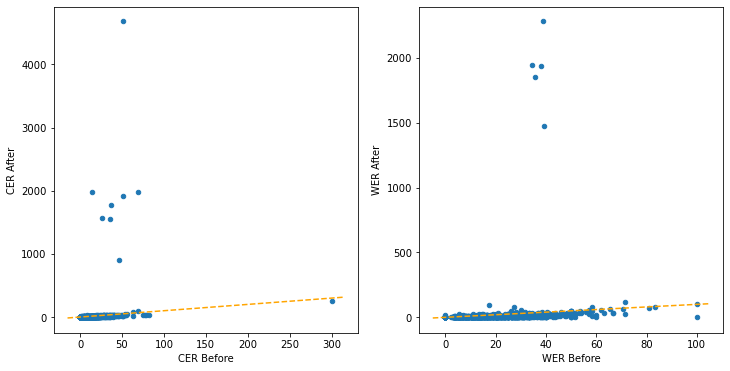

In [8]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
new_jw_er.plot(x = 'CER Before', y = 'CER After', kind='scatter',ax=ax[0])
xlim = ax[0].get_xlim()
ylim = ax[0].get_ylim()
ax[0].plot([xlim[0],xlim[1]], [xlim[0],xlim[1]], '--', color='orange')

new_jw_er.plot(x = 'WER Before', y = 'WER After', kind='scatter',ax=ax[1])
xlim = ax[1].get_xlim()
ylim = ax[1].get_ylim()
ax[1].plot([xlim[0],xlim[1]], [xlim[0],xlim[1]], '--', color='orange')

plt.show()

In [9]:
#average WER/CER
table = {
    "CER": [new_jw_er["CER Before"].mean(), new_jw_er["CER After"].mean(), new_jw_er["CER Before"].std(),new_jw_er["CER After"].std()], 
    "WER": [new_jw_er["WER Before"].mean(), new_jw_er["WER After"].mean(), new_jw_er["WER Before"].std(),new_jw_er["WER After"].std()], 

}
bad = pd.DataFrame(table, index = ["Average Before",'Average After"', 'SD Before', 'SD After'])
pd.options.display.max_colwidth = 300
bad

,CER,WER
Average Before,12.089078,19.501638
"Average After""",22.235737,17.435660
SD Before,15.319015,14.626448
SD After,204.694608,135.057964


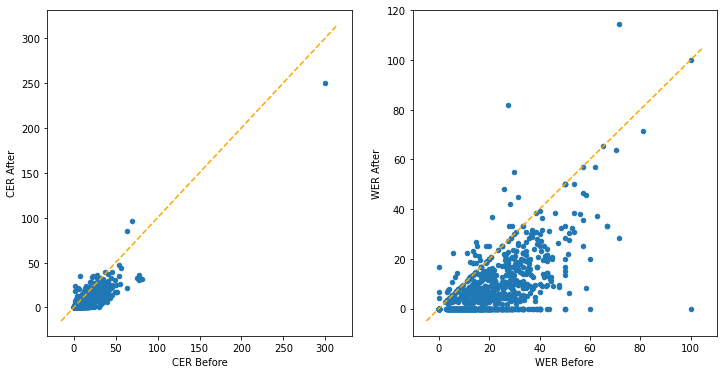

In [10]:
zoom = new_jw_er[new_jw_er['CER After'] < 500]
fig, ax = plt.subplots(1,2,figsize=(12,6))
zoom.plot(x = 'CER Before', y = 'CER After', kind='scatter',ax=ax[0])
xlim = ax[0].get_xlim()
ylim = ax[0].get_ylim()
ax[0].plot([xlim[0],xlim[1]], [xlim[0],xlim[1]], '--', color='orange')

zoom.plot(x = 'WER Before', y = 'WER After', kind='scatter',ax=ax[1])
xlim = ax[1].get_xlim()
ylim = ax[1].get_ylim()
ax[1].plot([xlim[0],xlim[1]], [xlim[0],xlim[1]], '--', color='orange')

plt.show()

In [26]:
#average WER/CER
table = {
    "CER": [zoom["CER Before"].mean(), zoom["CER After"].mean(), zoom["CER Before"].std(),zoom["CER After"].std()], 
    "WER": [zoom["WER Before"].mean(), zoom["WER After"].mean(), zoom["WER Before"].std(),zoom["WER After"].std()], 

}
bad = pd.DataFrame(table, index = ["Average Before",'Average After"', 'SD Before', 'SD After'])
pd.options.display.max_colwidth = 300
bad

,CER,WER
Average Before,11.852748,19.311366
"Average After""",5.950018,7.753715
SD Before,15.084934,14.435869
SD After,11.766735,11.603181


### Hallucination

In [25]:
hallu_c = new_jw_er[new_jw_er['CER After'] > 500]
hallu_c.head()
hallu_c[["source_word", "target_word", "predicted_text"]]

,source_word,target_word,predicted_text
150,The brightest sample is 83CRAR selected at MMIETZ. with a flux-density limit of στ> 10.9.J.]v (8124c 12.4]v. assuming a spectral index of 0.8): the faintest sample is TORS selected at MMLbIz. with a Ilux-densitv limit of Sy.)2 0.5.JJv.,"The brightest sample is 3CRR selected at MHz, with a flux-density limit of $S_{178}\n\geq 10.9$ Jy $S_{151} \geq 12.4$ Jy, assuming a spectral index of 0.8); the faintest sample is 7CRS selected at MHz, with a flux-density limit of $S_{151} \geq 0.5$ Jy.","The brightest sample is S3CRAR selected at MHz, with a flux-density limit of $\sigma_{\rm Fe, \rm Fe, \rm Fe, \rm Fe, \rm Fe, \rm Fe, \rm Fe, \rm Fe, \rm Fe, \rm Fe, \rm Fe, \rm Fe, \rm Fe, \rm Fe, \rm Fe, \rm Fe, \rm Fe, \rm Fe, \rm Fe, \rm Fe, \rm Fe, \rm Fe, \rm Fe, \rm Fe, \rm Fe, \rm Fe, \..."
172,"The presence of the Dirac function 0(k;:€,Κυ£22) in equation (38)) indicates that particles interact. resonantly.",The presence of the Dirac function $\delta({\mathbf{k}}_1\!\cdot {\mathbf{\Omega}}_1 - {\mathbf{k}}_2\!\cdot {\mathbf{\Omega}}_2)$ in equation \ref{LAequation}) ) indicates that particles interact resonantly.,The presence of the Dirac function $\delta(k_z; \epsilon_z; \kappa_0; \kappa_0; \Omega_0; \Omega_0; \Omega_0; \Omega_0; \Omega_0; \Omega_0; \Omega_0; \Omega_0; \Omega_0; \Omega_0; \Omega_0; \Omega_0; \Omega_0; \Omega_0; \Omega_0; \Omega_0; \Omega_0; \Omega_0; \Omega_0; \Omega_0; \Omega_0; \Omeg...
421,2. ts in fact dominated by intermediate-mass stars. as may be judged from the turnoff masses of the corresponding clusters. most of them being larger than 2 citepMermilliod-2007b..,"\ref{Fig:elogP_panels} is in fact dominated by intermediate-mass stars, as may be judged from the turnoff masses of the corresponding clusters, most of them being larger than 2 \\citep{Mermilliod-2007b}.",\ref{fig:mass_mass_mass_mass_mass_mass_mass_mass_mass_mass_mass_mass_mass_mass_mass_mass_mass_mass_mass_mass_mass_mass_mass_mass_mass_mass_mass_mass_mass_mass_mass_mass_mass_mass_mass_mass_mass_mass_mass_mass_mass_mass_mass_mass_mass_mass_mass_mass_mass_mass_mass_mass_mass_mass_mass_mass_mass_m...
458,"3 to 5)) that emanate from SGL~200°, SGB~30°.","\ref{Fig:3} to \ref{Fig:5}) ) that emanate from $SGL\sim 200\circ$, $SGB\sim 30\circ$.",\ref{fig:sgl_sgl} to \ref{fig:sgl_sgl_sgl_sgl_sgl_sgl_sgl_sgl_sgl_sgl_sgl_sgl_sgl_sgl_sgl_sgl_sgl_sgl_sgl_sgl_sgl_sgl_sgl_sgl_sgl_sgl_sgl_sgl_sgl_sgl_sgl_sgl_sgl_sgl_sgl_sgl_sgl_sgl_sgl_sgl_sgl_sgl_sgl_sgl_sgl_sgl_sgl_sgl_sgl_sgl_sgl_sgl_sgl_sgl_sgl_sgl_sgl_sgl_sgl_sgl_sgl_sgl_sgl_sgl_sgl_sgl_s...
477,"The observed. visibility phase. (5/. in a baseline with components (u,;;.0;05). due to calibrator S, with direction cosines (f°!mS!nF!) is given by: Where.⇁ ορETTui represents (rue instrumental; phases. ὁ;=1.2.....32 represents EW antennas and j=1.2.....045 represents NS antennas.","The observed visibility phase, $\psi_{ij}{\mathcal{S}{}_1}$, in a baseline with components $\left(u{}_{ij}, v{}_{ij}, w{}_{ij}\right)$, due to calibrator $S{}_{1}$ with direction cosines $\left(l{\mathcal{S}_1},m{\mathcal{S}_1},n{\mathcal{S}_1}\right)$, is given by: Where, $\phi_{ij}{\mbox{\sma...","The observed visibility phase, $\phi_{obs}$, in a baseline with components $(u_{ij},v_{ij},v_{ij})$, due to calibrator $S_{i}$ with direction cosines $(\int ^{\infty} \cdot \int ^{\infty} \cdot \int ^{\infty} \cdot \int ^{\infty} \cdot \int ^{\infty} \cdot \int ^{\infty} \cdot \int ^{\infty} \c..."
664,"This can he interpreted as a consequence of extremely strong scattering. (Lp,iU!ἐν)exp(U)Z91. when the main pulse intensity is almost completely. transferred to the precursor. Z,,—70. laiiNote .","This can be interpreted as a consequence of extremely strong scattering, $(I_{\nu_b}{(0)}/I_{\nu_a}{(0)})\exp (\Gamma)\gg 1$, when the main pulse intensity is almost completely transferred to the precursor, $I_{\nu_a}\to 0$, $I_{\nu_b}\to I_{\nu_a}{(0)}$.","This can be interpreted as a consequence of extremely 

In [22]:
hallu_c.iloc[0]

source                                                                            The brightest sample is 83CRAR selected at MMIETZ. with a flux-density limit of στ> 10.9.J.]v (8124c 12.4]v. assuming a spectral index of 0.8): the faintest sample is TORS selected at MMLbIz. with a Ilux-densitv limit of Sy.)2 0.5.JJv.
target                                                         The brightest sample is 3CRR selected at MHz, with a flux-density limit of $S_{178}\n\geq 10.9$ Jy $S_{151} \geq 12.4$ Jy, assuming a spectral index of 0.8); the faintest sample is 7CRS selected at MHz, with a flux-density limit of $S_{151} \geq 0.5$ Jy.
aligned source                                                                    WWW WWWWWWWWW WWWWWW WW WWWWWW WWWWWWWW WW WWWWWWW WWWW W WWWWWWWWWWWW WWWWW WW WWW WWWWWWWWW WWWWWW WWWWWWW WWWWWWWW W WWWWWWWW WWWWW WW WWWWW WWW WWWWWWWW WWWWWW WW WWWW WWWWWWWW WW WWWWWWW WWWW W WWWWWWWWWWWW WWWWW WW WWWWW WWWWWWWW
aligned target                                

In [17]:
hallu_w = new_jw_er[new_jw_er['WER After'] > 500]
hallu_w.shape[0]

5

In [27]:
hallu_w[["source_word", "target_word", "predicted_text"]]

,source_word,target_word,predicted_text
150,The brightest sample is 83CRAR selected at MMIETZ. with a flux-density limit of στ> 10.9.J.]v (8124c 12.4]v. assuming a spectral index of 0.8): the faintest sample is TORS selected at MMLbIz. with a Ilux-densitv limit of Sy.)2 0.5.JJv.,"The brightest sample is 3CRR selected at MHz, with a flux-density limit of $S_{178}\n\geq 10.9$ Jy $S_{151} \geq 12.4$ Jy, assuming a spectral index of 0.8); the faintest sample is 7CRS selected at MHz, with a flux-density limit of $S_{151} \geq 0.5$ Jy.","The brightest sample is S3CRAR selected at MHz, with a flux-density limit of $\sigma_{\rm Fe, \rm Fe, \rm Fe, \rm Fe, \rm Fe, \rm Fe, \rm Fe, \rm Fe, \rm Fe, \rm Fe, \rm Fe, \rm Fe, \rm Fe, \rm Fe, \rm Fe, \rm Fe, \rm Fe, \rm Fe, \rm Fe, \rm Fe, \rm Fe, \rm Fe, \rm Fe, \rm Fe, \rm Fe, \rm Fe, \..."
172,"The presence of the Dirac function 0(k;:€,Κυ£22) in equation (38)) indicates that particles interact. resonantly.",The presence of the Dirac function $\delta({\mathbf{k}}_1\!\cdot {\mathbf{\Omega}}_1 - {\mathbf{k}}_2\!\cdot {\mathbf{\Omega}}_2)$ in equation \ref{LAequation}) ) indicates that particles interact resonantly.,The presence of the Dirac function $\delta(k_z; \epsilon_z; \kappa_0; \kappa_0; \Omega_0; \Omega_0; \Omega_0; \Omega_0; \Omega_0; \Omega_0; \Omega_0; \Omega_0; \Omega_0; \Omega_0; \Omega_0; \Omega_0; \Omega_0; \Omega_0; \Omega_0; \Omega_0; \Omega_0; \Omega_0; \Omega_0; \Omega_0; \Omega_0; \Omeg...
477,"The observed. visibility phase. (5/. in a baseline with components (u,;;.0;05). due to calibrator S, with direction cosines (f°!mS!nF!) is given by: Where.⇁ ορETTui represents (rue instrumental; phases. ὁ;=1.2.....32 represents EW antennas and j=1.2.....045 represents NS antennas.","The observed visibility phase, $\psi_{ij}{\mathcal{S}{}_1}$, in a baseline with components $\left(u{}_{ij}, v{}_{ij}, w{}_{ij}\right)$, due to calibrator $S{}_{1}$ with direction cosines $\left(l{\mathcal{S}_1},m{\mathcal{S}_1},n{\mathcal{S}_1}\right)$, is given by: Where, $\phi_{ij}{\mbox{\sma...","The observed visibility phase, $\phi_{obs}$, in a baseline with components $(u_{ij},v_{ij},v_{ij})$, due to calibrator $S_{i}$ with direction cosines $(\int ^{\infty} \cdot \int ^{\infty} \cdot \int ^{\infty} \cdot \int ^{\infty} \cdot \int ^{\infty} \cdot \int ^{\infty} \cdot \int ^{\infty} \c..."
664,"This can he interpreted as a consequence of extremely strong scattering. (Lp,iU!ἐν)exp(U)Z91. when the main pulse intensity is almost completely. transferred to the precursor. Z,,—70. laiiNote .","This can be interpreted as a consequence of extremely strong scattering, $(I_{\nu_b}{(0)}/I_{\nu_a}{(0)})\exp (\Gamma)\gg 1$, when the main pulse intensity is almost completely transferred to the precursor, $I_{\nu_a}\to 0$, $I_{\nu_b}\to I_{\nu_a}{(0)}$.","This can be interpreted as a consequence of extremely strong scattering, $(I_{\rm P_{\rm P_{\rm P_{\rm P_{\rm P_{\rm P_{\rm P_{\rm P_{\rm P_{\rm P_{\rm P_{\rm P_{\rm P_{\rm P_{\rm P_{\rm P_{\rm P_{\rm P_{\rm P_{\rm P_{\rm P_{\rm P_{\rm P_{\rm P_{\rm P_{\rm P_{\rm P_{\rm P_{\rm P_{\rm P_{\rm P_{..."
666,"In case of a moderately strong scattering. VIPiii1)exp(E)H~I. the main. pulse intensity. Z5,iU. is almost unchanged. whereas the precursor grows exponentially with I5","In case of a moderately strong scattering, $(I_{\nu_b}{(0)}/I_{\nu_a}{(0)})\exp (\Gamma)\sim 1$, the main pulse intensity $I_{\nu_a}{(0)}$ is almost unchanged, whereas the precursor grows exponentially with $I_{\nu_a}{(0)}$.","In case of a moderately strong scattering, $\sqrt{\Gamma_{\rm p}(\Gamma_{\rm p}, \Gamma_{\rm p}, \Gamma_{\rm p}, \Gamma_{\rm p}, \Gamma_{\rm p}, \Gamma_{\rm p}, \Gamma_{\rm p}, \Gamma_{\rm p}, \Gamma_{\rm p}, \Gamma_{\rm p}, \Gamma_{\rm p}, \Gamma_{\rm p}, \Gamma_{\rm p}, \Gamma_{\rm p}, \Gamma..."


In [35]:
if "\"" in hallu_w.iloc[0]["predicted_text"]:
    print('yes')

In [31]:
hallu_w.iloc[0]["predicted_text"].contain

' The brightest sample is S3CRAR selected at MHz, with a flux-density limit of $\\sigma_{\\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\rm Fe, \\

## 